In [41]:
import xgboost
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin # Needed to do custom pipeline things

In [42]:
features_race = ['white_alone_percent_cen', 'black_alone_percent_cen',
       'indigenous_alone_percent_cen', 'asian_alone_percent_cen',
       'pacific_islander_alone_percent_cen', 'other_alone_percent_cen',
       'multiracial_percent_cen']

features_transit_type = ['work_from_home_percent_cen',
       'automobile_to_work_percent_cen', 'public_transit_to_work_percent_cen',
       'taxi_to_work_percent_cen', 'motorcycle_to_work_percent_cen',
       'bike_to_work_percent_cen', 'walk_to_work_percent_cen',
       'other_to_work_percent_cen']

features_education = ['lt_9th_percent_cen',
       'no_diploma_percent_cen', 'high_school_percent_cen',
       'some_college_percent_cen', 'associates_percent_cen',
       'bachelors_percent_cen', 'graduate_degree_percent_cen']

features_employment = ['in_labor_force_20_64_percent_cen',
       'not_in_labor_force_20_64_percent_cen', 'unemployed_20_64_percent_cen',
       'below_poverty_line_percent_cen']

features = features_race + features_transit_type + features_education + features_employment + ['median_household_income_cen',
       'median_age_cen', 'polling_accessible', 'walking_transit_travel_time', 'driving_travel_time']

Here, we read in the training dataset.

In [43]:
data = gpd.read_file('../project_data/final_dataset/train_final_dataset_Chicago_no_outlier.geojson')
X= data[features]
y= data['VoterTurnoutPercentage'].values

In [44]:
data_train, data_val = train_test_split(data, test_size=0.2)
X_train, y_train = data_train[features], data_train['VoterTurnoutPercentage']
X_val, y_val = data_val[features], data_val['VoterTurnoutPercentage']
# X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.20)

# Plotting Features vs VoterTurnoutPercentage

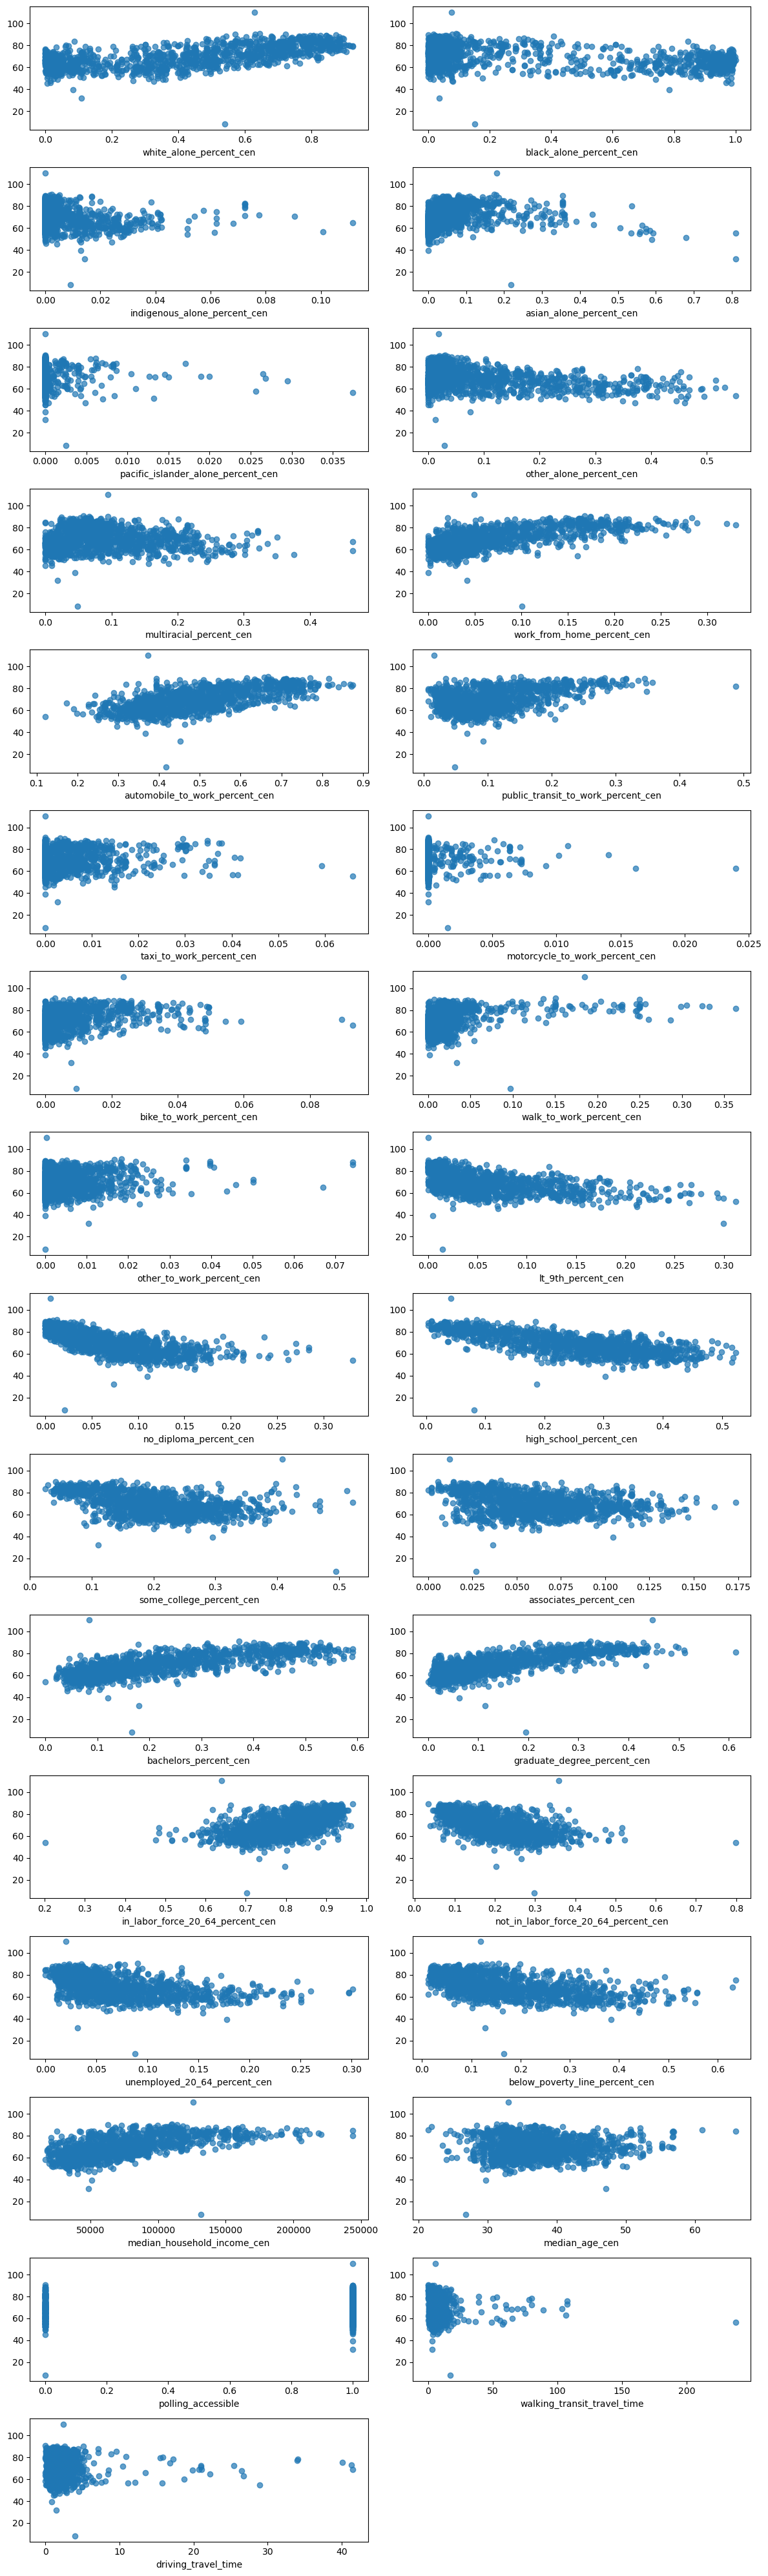

In [45]:
# Define the number of rows and columns for the grid
num_features = X_train.shape[1]
num_cols = 2  # Choose number of columns for layout
num_rows = (num_features + num_cols - 1) // num_cols  # Calculate rows needed

# Create the grid of plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8 + num_rows * 2))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature against y_train
for i, column in enumerate(X_train.columns):
    axes[i].scatter(X_train[column], y_train.values, alpha=0.7)
    # axes[i].set_title(f'{column} vs VoterTurnoutPercentage')
    axes[i].set_xlabel(column)
    # axes[i].set_ylabel('VoterTurnoutPercentage')

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

# Baseline model

In [46]:
class baseline():
    def __init__(self):
        self.y_predict = None
    def fit(self, X_train,y_train):

        self.y_predict = np.mean(y_train)

    def predict(self, X_predict):
        return self.y_predict * np.ones(len(X_predict))
        

        
        
    

In [47]:

base = baseline()
base.fit(X_train, y_train)
y_predict_base = base.predict(X_val)
rmse_base = root_mean_squared_error(y_predict_base, y_val)
print(rmse_base)

9.5704035838946


So the number to beat is ~9-10% (after rerunning a few times)

# Linear regression

In [48]:
pipe_lr = Pipeline([('scale',StandardScaler()),('reg',LinearRegression())])
pipe_lr.fit(X_train,y_train)
y_predict_lr = pipe_lr.predict(X_val)
rmse_lr = root_mean_squared_error(y_predict_lr, y_val)
print(rmse_lr)

5.058701052111024


# XGBoost

In [49]:
xgb_reg = xgboost.XGBRegressor(learning_rate=.05,
                                   max_depth=5,
                                   n_estimators=100,verbosity=3)
xgb_reg.fit(X_train, y_train,eval_set=[(X_val, y_val)])
y_predict_xgb = xgb_reg.predict(X_val)
rmse_xgb = root_mean_squared_error(y_predict_xgb, y_val)


[19:29:24] ======== Monitor (0): HostSketchContainer ========
[19:29:24] AllReduce: 0.001246s, 1 calls @ 1246us

[19:29:24] MakeCuts: 0.001398s, 1 calls @ 1398us

[19:29:24] DEBUG: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807611129/work/src/gbm/gbtree.cc:130: Using tree method: 0
[0]	validation_0-rmse:9.24266
[1]	validation_0-rmse:8.93423
[2]	validation_0-rmse:8.63718
[3]	validation_0-rmse:8.35999
[4]	validation_0-rmse:8.10752
[5]	validation_0-rmse:7.86770
[6]	validation_0-rmse:7.63749
[7]	validation_0-rmse:7.43212
[8]	validation_0-rmse:7.24076
[9]	validation_0-rmse:7.05528
[10]	validation_0-rmse:6.89505
[11]	validation_0-rmse:6.73638
[12]	validation_0-rmse:6.59469
[13]	validation_0-rmse:6.46093
[14]	validation_0-rmse:6.34138
[15]	validation_0-rmse:6.21993
[16]	validation_0-rmse:6.11361
[17]	validation_0-rmse:6.01323
[18]	validation_0-rmse:5.92045
[19]	validation_0-rmse:5.83087
[20]	validation_0-rmse:5.74594
[21]	validation_0-rmse:5.66340
[22]	validation_0-rmse:5.59788
[23]

In [50]:
print(rmse_xgb)

4.667313867307369


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

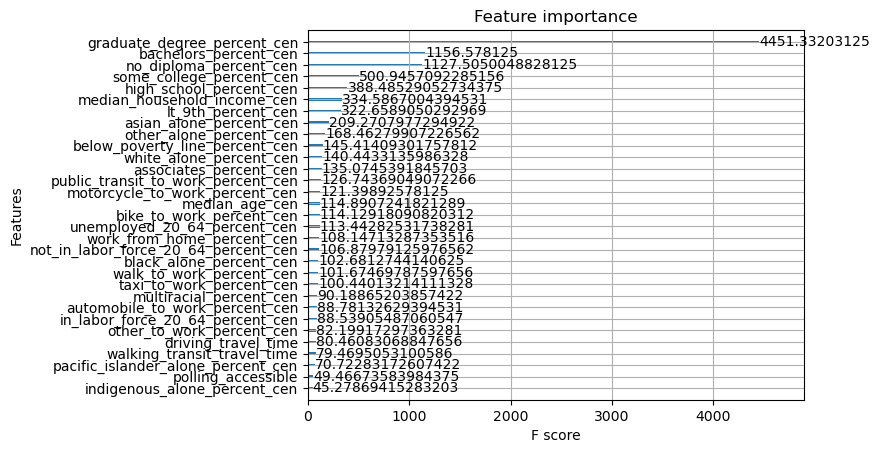

In [51]:
xgboost.plot_importance(xgb_reg, importance_type = 'gain')

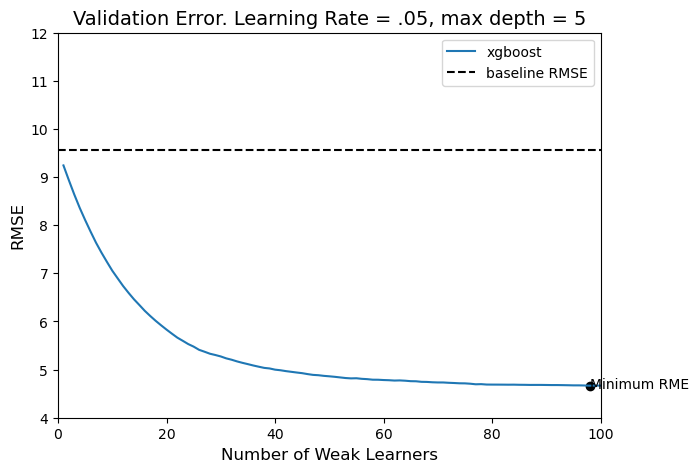

In [52]:
plt.figure(figsize=(7,5))

plt.plot(range(1,len(xgb_reg.evals_result()['validation_0']['rmse'])+1), 
         xgb_reg.evals_result()['validation_0']['rmse'], label = 'xgboost')
plt.scatter([range(1,len(xgb_reg.evals_result()['validation_0']['rmse'])+1)[np.argmin(xgb_reg.evals_result()['validation_0']['rmse'])]], 
            [np.min(xgb_reg.evals_result()['validation_0']['rmse'])], c='k')
plt.text(range(1,len(xgb_reg.evals_result()['validation_0']['rmse'])+1)[np.argmin(xgb_reg.evals_result()['validation_0']['rmse'])], 
         np.min(xgb_reg.evals_result()['validation_0']['rmse'])-.05, "Minimum RME", fontsize=10)

plt.hlines(rmse_base, 0,200, linestyle='--',color = 'k',label = 'baseline RMSE')

plt.title("Validation Error. Learning Rate = .05, max depth = 5", fontsize=14)
plt.xlabel("Number of Weak Learners", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.xlim(0,100)
plt.ylim(4,12)
plt.legend()
plt.show()

In [53]:
print('Baseline RMSE: {}'.format(rmse_base))
print('Linear Regression RMSE: {}'.format(rmse_lr))
print('XGBoost RMSE: {}'.format(rmse_xgb))

Baseline RMSE: 9.5704035838946
Linear Regression RMSE: 5.058701052111024
XGBoost RMSE: 4.667313867307369


# Using `statsmodels`

According to the results in this section, we find that essentially all of the features have significant influence on voter turnout. This aligns with what we found from the XGBoost section and the (categorical) Logistic Regression section.

In [54]:
import statsmodels.api as sm

In [69]:
# First, scale the data.
scaler = StandardScaler()
X_train_scaled = gpd.GeoDataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

full_model = sm.OLS(y_train.values, sm.add_constant(X_train_scaled).values).fit()

def perform_f_test(X, full_features, reduced_features):
    X_train_full = X[full_features]
    X_train_reduced = X[reduced_features]

    # Create the models
    full_model = sm.OLS(y_train.values, sm.add_constant(X_train_full).values).fit()
    reduced_model = sm.OLS(y_train.values, sm.add_constant(X_train_reduced).values).fit()

    # Perform the F-test
    f_test = full_model.compare_f_test(reduced_model)

    # Print the results
    print("F-statistic:", f_test[0])
    print("p-value:", f_test[1])

### Travel time only
First, we use the reduced model with only the features `'walking_transit_travel_time'` and `'driving_travel_time'`.

In [70]:
perform_f_test(X_train_scaled, features, ['walking_transit_travel_time', 'driving_travel_time'])

F-statistic: 111.58858549228721
p-value: 2.495034077669466e-307


Evidently, we should reject the reduced model.

### Education/Employment only

In [71]:
perform_f_test(X_train_scaled, features, features_education + features_employment)

F-statistic: 9.470478387020616
p-value: 3.5264816079827085e-26


Evidently, we should reject the reduced model.

### Education/Employment + travel time only

In [72]:
perform_f_test(X_train_scaled, features, features_education + features_employment + ['walking_transit_travel_time', 'driving_travel_time'])

F-statistic: 9.97313764215768
p-value: 2.442499766729594e-25


Evidently, we should reject the reduced model.

### Education/Employment + travel time only + median income

In [73]:
perform_f_test(X_train_scaled, features, features_education + features_employment 
               + ['walking_transit_travel_time', 'driving_travel_time', 'median_household_income_cen'])

F-statistic: 10.572395404775992
p-value: 9.075124728063498e-26


### All but race

In [74]:
perform_f_test(X_train_scaled, features, features_transit_type + features_education + features_employment 
               + ['median_household_income_cen', 'median_age_cen', 'polling_accessible', 'walking_transit_travel_time', 
                  'driving_travel_time'])

F-statistic: 18.933087856874398
p-value: 3.254045441162033e-21


# Logistic Regression (Categorical)

## Unweighted Categorical

We use logistic regression. We see below that the median voter turnout percentage is approximately 70, so we used that as a cutoff percentage for labelling.

In [75]:
from sklearn.linear_model import LogisticRegression

In [76]:
print(data['VoterTurnoutPercentage'].median())
cutoff_percentage = 70

69.265


In [77]:
# A function to create the labels based on the cutoff percentage.
def make_labels(y_train):
    return 1.0*(y_train >= cutoff_percentage)

# Create the pipeline.
pipe_logr = Pipeline([('scale', StandardScaler()),
                      ('logr', LogisticRegression())])

# Do the logistic regression.
pipe_logr.fit(X_train, make_labels(y_train))

# Score!
pipe_logr.score(X_val, make_labels(y_val))

0.8393939393939394

As can be seen from the bar chart below, the features like `graduate_degree_percent_cen` and `high_school_percent_cen` have the most impact on voter turnout (or more precisely, whether the voter turnout is above 70%). This aligns with the results of XGBoost.

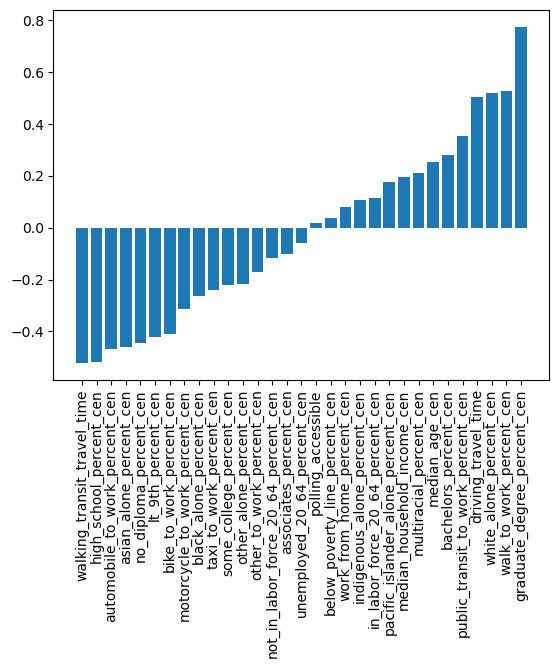

In [78]:
# Create the dictionary of feature names and coefficients
coeff_dict_logr = dict(zip(features, pipe_logr.named_steps['logr'].coef_[0]))

# Convert the dictionary to a DataFrame
coeff_df_logr = pd.DataFrame(coeff_dict_logr.items(), columns=['Feature', 'Coefficient'])

coeff_df_logr.sort_values('Coefficient', inplace=True)
xx = np.arange(coeff_df_logr.shape[0])
plt.bar(xx, coeff_df_logr['Coefficient'])
plt.gca().xaxis.set_ticks(xx)
plt.gca().xaxis.set_ticklabels(coeff_df_logr['Feature'], rotation=90)
plt.show()

## Weighted Categorical
The only difference here is that we're weighting each precinct by `total_population_cen`.

In [79]:
def make_weights(data):
    return data['total_population_cen']

# Create the pipeline.
pipe_wt_logr = Pipeline([('scale', StandardScaler()),
                         ('wt_logr', LogisticRegression())])

# Do the logistic regression.
pipe_wt_logr.fit(X_train, make_labels(y_train), wt_logr__sample_weight=data_train['total_population_cen'])

# Score!
pipe_wt_logr.score(X_val, make_labels(y_val), wt_logr__sample_weight=data_val['total_population_cen'])

0.8545454545454545

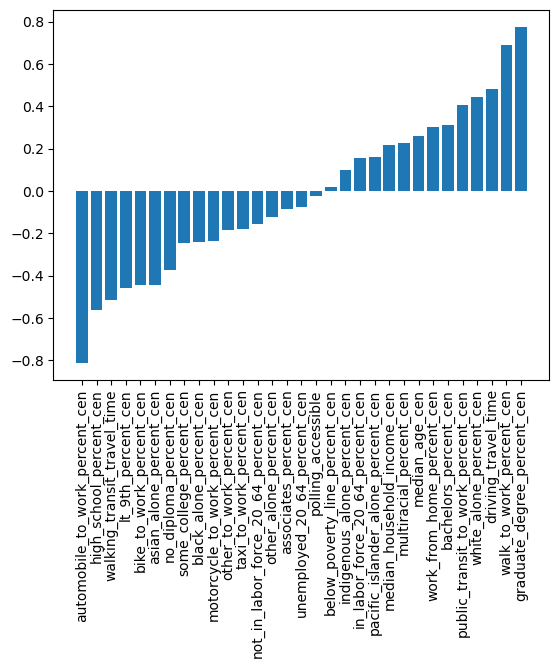

In [80]:
# Create the dictionary of feature names and coefficients
coeff_dict_wt_logr = dict(zip(features, pipe_wt_logr.named_steps['wt_logr'].coef_[0]))

# Convert the dictionary to a DataFrame
coeff_df_wt_logr = pd.DataFrame(coeff_dict_wt_logr.items(), columns=['Feature', 'Coefficient'])

coeff_df_wt_logr.sort_values('Coefficient', inplace=True)
xx = np.arange(coeff_df_wt_logr.shape[0])
plt.bar(xx, coeff_df_wt_logr['Coefficient'])
plt.gca().xaxis.set_ticks(xx)
plt.gca().xaxis.set_ticklabels(coeff_df_wt_logr['Feature'], rotation=90)
plt.show()

## Cross Validation

In [81]:
kfold_logr = KFold(n_splits=5, shuffle=True)
X_train_with_pop = data_train[features + ['total_population_cen']]

# scores will hold the cross validation score of each model.
scores = np.zeros((2,5))

for i, (train_index, val_index) in enumerate(kfold_logr.split(X_train_with_pop, y_train)):
    ## get the kfold training data
    X_train_train = X_train_with_pop.iloc[train_index,:][features]
    sample_weight_train = X_train_with_pop.iloc[train_index,:]['total_population_cen']
    y_train_train = y_train.iloc[train_index]
    
    ## get the holdout data
    X_train_holdout = X_train_with_pop.iloc[val_index,:][features]
    sample_weight_holdout = X_train_with_pop.iloc[val_index,:]['total_population_cen']
    y_train_holdout = y_train.iloc[val_index]

    ## train the models
    pipe_logr.fit(X_train_train, make_labels(y_train_train))
    pipe_wt_logr.fit(X_train_train, make_labels(y_train_train), wt_logr__sample_weight=sample_weight_train)

    ## compute the scores
    scores[0,i] = pipe_logr.score(X_train_holdout, make_labels(y_train_holdout))
    scores[1,i] = pipe_wt_logr.score(X_train_holdout, make_labels(y_train_holdout), wt_logr__sample_weight=sample_weight_holdout)

In [82]:
scores

array([[0.81439394, 0.83269962, 0.82129278, 0.85171103, 0.84790875],
       [0.81818182, 0.82509506, 0.79087452, 0.85171103, 0.84410646]])

Evidently, the weighted logistic regression performs basically exactly as well as the unweighted logistic regression.

### Comparing the coefficients
Except for `unemployed_20_64_percent_cen` (which in both models has almost not effect), the features which are negatively correlated with `VoterTurnoutPercentage>=70` and positively correlated with `VoterTurnoutPercentage>=70`, respectively, are the same in both models.

`graduate_degree_percent_cen` is  the largest contributor for both. All changes in the order of the sorted list of coefficients from one model to the other is explained by some features contributing a similar amounnt (read: their coefficients are approximately the same).

In [83]:
coeff_df_logr.merge(coeff_df_wt_logr, on='Feature')

,Feature,Coefficient_x,Coefficient_y
0,walking_transit_travel_time,-0.520420,-0.512996
1,high_school_percent_cen,-0.518851,-0.562270
2,automobile_to_work_percent_cen,-0.466021,-0.811141
3,asian_alone_percent_cen,-0.460956,-0.443868
4,no_diploma_percent_cen,-0.444184,-0.372394
5,lt_9th_percent_cen,-0.423053,-0.456815
6,bike_to_work_percent_cen,-0.411240,-0.445604
7,motorcycle_to_work_percent_cen,-0.311494,-0.237772
8,black_alone_percent_cen,-0.262595,-0.242413
9,taxi_to_work_percent_cen,-0.239942,-0.179211


### Choosing a logistic regression model
Based on the above analysis in this section, adding the weights makes no appreciable difference. So, we suggest using the unweighted logistic regression model.

# Logistic Regression (Non-Categorical)

We use weighted logistic regression. The labels are "1" for "voted" and "0" for "didn't vote". The weights for "1" are
$$ \frac{\mathrm{VoterTurnoutPercentage}}{100} \cdot \mathrm{\mathrm{total\_population}},$$
while the weights for "0" are
$$ \left(1 - \frac{\mathrm{VoterTurnoutPercentage}}{100}\right) \cdot \mathrm{\mathrm{total\_population}}.$$

WARNING! We're using `total_population` rather than `elligible_voting_population`, since we didn't pull the latter.

In [94]:
class DataDuplicator(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_duplicated = np.vstack([X, X])
        return X_duplicated

def make_labels(X):
    # 0's come first!
    return np.concatenate([np.zeros(len(X)), np.ones(len(X))])

def make_weights(pop, turnout):
    return pd.concat([(1-turnout/100) * pop,
                      turnout/100 * pop])

In [95]:
pipe_logr2 = Pipeline([('scale', StandardScaler()),
                      ('dup', DataDuplicator()),
                      ('logr', LogisticRegression())])

pipe_logr2.fit(X_train, make_labels(X_train), 
               logr__sample_weight=make_weights(data_train['total_population_cen'], y_train))

Pipeline(steps=[('scale', StandardScaler()), ('dup', DataDuplicator()),
                ('logr', LogisticRegression())])

In [96]:
predictions_logr2 = pipe_logr2.predict_proba(X_val)[:len(X_val),1]
100 * root_mean_squared_error(predictions_logr2, y_val/100)

np.float64(5.1335413650125465)

# Logistic Regression (Non-Categorical) vs. Linear Regression

We see below that there's no appreciable difference in performance between the logistic regression and the linear regression.

In [123]:
kfold = KFold(n_splits=5, shuffle=True)

# rmses will hold the cross validation score of each model.
rmses = np.zeros((2,5))

for i, (train_index, val_index) in enumerate(kfold.split(X_train, y_train)):
    ## get the kfold training data
    cv_X_train = X_train.iloc[train_index,:]
    cv_y_train = y_train.iloc[train_index]

    ## get the weights
    sample_weight_train = make_weights(data_train.iloc[train_index,:]['total_population_cen'], cv_y_train)
    
    ## get the holdout data
    cv_X_holdout = X_train.iloc[val_index,:][features]
    cv_y_holdout = y_train.iloc[val_index]

    ## train the models
    pipe_logr2.fit(cv_X_train, make_labels(cv_y_train), logr__sample_weight=sample_weight_train)
    pipe_lr.fit(cv_X_train, cv_y_train)

    ## predict
    predictions_logr2 = pipe_logr2.predict_proba(cv_X_holdout)[:len(cv_X_holdout),1] # Remember that the pipe duplicates X!
    predictions_lr = pipe_lr.predict(cv_X_holdout)

    ## compute the rmses
    rmses[0, i] = 100 * root_mean_squared_error(predictions_logr2, cv_y_holdout/100)
    rmses[1, i] = root_mean_squared_error(predictions_lr, cv_y_holdout)
    

In [124]:
rmses

array([[6.50215752, 5.34920434, 5.69225483, 5.49603079, 4.91710715],
       [6.35616435, 5.39910063, 5.59064563, 5.62120074, 4.89651127]])